In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import minimize
import geatpy as ea
plt.rcParams.update({'font.size': 15})

In [10]:
with open('data/training_set_ip_temp_200Hz_passive_RP_3.p', 'rb') as fo:
        X_train = pickle.load(fo, encoding='bytes')
with open('data/training_set_op_temp_200Hz_passive_RP_3.p', 'rb') as fo:
        Y_train = pickle.load(fo, encoding='bytes')
with open('data/testing_set_ip_temp_200Hz_passive_RP_3.p', 'rb') as fo:
        X_test = pickle.load(fo, encoding='bytes')
with open('data/testing_set_op_temp_200Hz_passive_RP_3.p', 'rb') as fo:
        Y_test = pickle.load(fo, encoding='bytes')

In [11]:
# standardization
Y_train_std = np.empty_like(Y_train)
Y_test_std = np.empty_like(Y_test)
Y_train_std = (Y_train - np.mean(Y_train)) / np.std(Y_train)
Y_test_std = (Y_test - np.mean(Y_test)) / np.std(Y_test)

In [12]:
# change the input from the list to array
Nsyn = 9
time_dur = Y_train.shape[1]
def list2array(X):
    ip_dim = Nsyn
    ip_num = int(len(X) / ip_dim)
    X_array = np.zeros((ip_num, ip_dim, time_dur))
    for i in range(ip_num):
        for j in range(ip_dim):
            for spike_time in X[i*Nsyn+j]:
                if spike_time <= 1000:
                    X_array[i,j,int(spike_time)] += 1
    return X_array

X_train_array = list2array(X_train)
X_test_array = list2array(X_test)

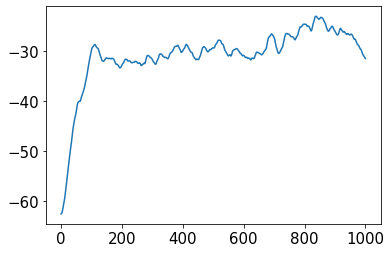

In [13]:
plt.plot(Y_train[0])

In [7]:
def kernel(tau_rise, tau_decay):
    T = np.arange(time_dur)
    y = (1 - np.exp(-T / tau_rise)) * np.exp(-T / tau_decay)
    return y

def sigmoid(X, c, theta):
    y = c / (1 + np.exp(-(X - theta)))
    return y

def model(X, Omega, Tau_rise, Tau_decay, K, v0):
    # X is one sample here
    Y = np.zeros(time_dur)
    L = np.zeros((Nsyn, time_dur))
    for i in range(Nsyn):
        ker = kernel(Tau_rise[i], Tau_decay[i])
        L[i] = Omega[i]*np.convolve(X[i], ker)[:time_dur]
        Y += L[i]
        if i > 0:
            for j in range(i):
                Y += -K[int(i*(i-1)/2)+j] * L[i] * L[j]
    return Y + v0

def hlm(X, Omega, Tau_rise, Tau_decay, K, v0):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model(X[i], Omega, Tau_rise, Tau_decay, K, v0)
    return Y

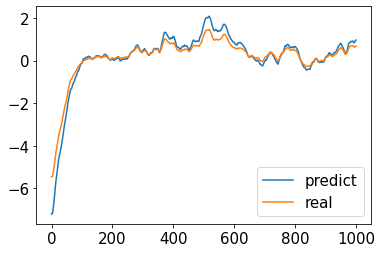

In [55]:
Vars = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
                 8, 8, 8, 8, 8, 8, 8, 8, 8,
                 50, 50, 50, 50, 50, 50, 50, 50, 50,
                 0.01, 
                 0.01, 0.01, 
                 0.01, 0.01, 0.01, 
                 0.01, 0.01, 0.01, 0.01, 
                 0.01, 0.01, 0.01, 0.01, 0.01, 
                 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 
                 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 
                 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
                 -7.2]) #+ np.random.randn(64) * 0.5
y = model(X_test_array[1], Vars[0:9], Vars[9:18], Vars[18:27], Vars[27:63], Vars[63])
plt.plot(y, label='predict')
plt.plot(Y_test_std[1], label='real')
plt.legend()

In [56]:
def evalVars(Vars):
    y = hlm(X_train_array, Vars[0:9], Vars[9:18], Vars[18:27], Vars[27:63], Vars[63])
    #y = hlm_non2(X_train_array, Vars[0:9], Vars[9:18], Vars[18:27], Vars[27], Vars[28], Vars[29])
    #y = hlm_l(X_train_array, Vars[0:9], Vars[9:18], Vars[18:27], Vars[27])
    #y = hlm_old(X_train_array, Vars[0:9], Vars[9:18], Vars[18], Vars[19], Vars[20])
    f = np.mean(np.square(y[:,200:] - Y_train_std[:,200:]))
    return f

In [57]:
evalVars(Vars)

0.0351973701819302

In [58]:
res = minimize(evalVars, x0=Vars, method='BFGS', options={'disp': True, 'maxiter' : 50})
with open('pars/pars_b+b_200Hz_passive_EI_RP_new.p', 'wb') as f:
    pickle.dump(res.x, f)

         Current function value: 0.000803
         Iterations: 50
         Function evaluations: 4160
         Gradient evaluations: 64


In [20]:
res.x

array([ 5.31863086e-01,  3.88094424e-01,  4.47565139e-01, -2.52667413e-02,
        4.04223889e-01,  2.92841073e-01,  2.32231380e-01,  4.14608859e-01,
        3.01688076e-01,  6.32225054e+00,  6.66877543e+00,  7.56352981e+00,
        7.86446839e+00,  7.70294591e+00,  6.75469776e+00,  7.16994624e+00,
        7.07205559e+00,  3.93197416e+00,  4.91641368e+01,  4.93988710e+01,
        4.97709042e+01,  5.01377227e+01,  4.98260664e+01,  4.94068206e+01,
        4.95453825e+01,  4.95452141e+01,  4.79868634e+01,  3.48154102e-02,
        3.92210667e-02,  4.80483234e-02,  5.66261119e-01, -2.55179774e-01,
       -2.05148655e-02,  3.93225617e-02,  1.44458276e-02,  3.60331938e-02,
       -3.06312405e-02,  2.40684491e-02,  1.00682988e-02,  2.34961067e-02,
        4.12755995e-01,  6.83628681e-02,  9.26750560e-02, -1.81098650e-02,
        1.80867522e-03, -7.05231843e-02,  4.67856194e-02, -8.52802521e-03,
        1.69230499e-02,  4.48588966e-03,  3.99025668e-02,  1.01441510e-01,
        3.33554293e-02,  

In [86]:
with open('pars/pars_b+b_passive_200Hz_weak.p', 'rb') as fo:
    Vars_bb = pickle.load(fo, encoding='bytes')

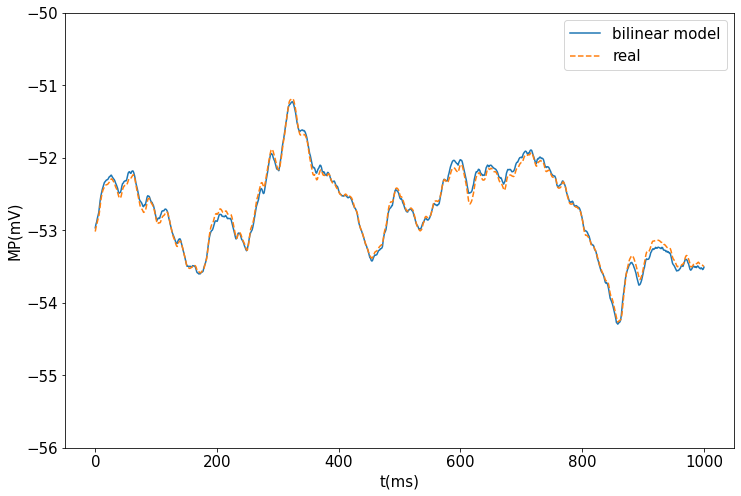

In [101]:
#Vars_non = res.x
#Vars_bb = res.x
#Vars_l = res.x
#Vars_old = res.x
idx = 7
plt.figure(figsize=(12,8))
t = np.linspace(0, 1000, 870)
y = model(X_test_array[idx], Vars_bb[0:9], Vars_bb[9:18], Vars_bb[18:27], Vars_bb[27:63], Vars_bb[63])
# y2 = model_non2(X_train_array[idx], Vars_non[0:9], Vars_non[9:18], Vars_non[18:27], Vars_non[27], Vars_non[28], Vars_non[29])
# y3 = model_old(X_train_array[idx], Vars_old[0:9], Vars_old[9:18], Vars_old[18], Vars_old[19], Vars_old[20])
# y4 = model_l(X_train_array[idx], Vars_l[0:9], Vars_l[9:18], Vars_l[18:27], Vars_l[27])

plt.plot(t, y[131:]*np.std(Y_train)+np.mean(Y_train), label='bilinear model')
# plt.plot(y2*np.std(Y_train)+np.mean(Y_train), label='new(nonlinear)')
# plt.plot(y4*np.std(Y_train)+np.mean(Y_train), label='new(linear)')
# plt.plot(y3*np.std(Y_train)+np.mean(Y_train), label='old(nonlinear)')
plt.plot(t, Y_test[idx][131:], '--', label='real')

# plt.plot(y*0.8975-62.731, label='b+b')
# plt.plot(y2*0.8975-62.731, label='non+b')
# plt.plot(y3*0.8975-62.731, label='non+a')
# plt.plot(y4*0.8975-62.731, label='lin+b')
plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')
plt.ylim(-56, -50)
plt.legend()
plt.savefig('figure/result_200Hz_3.png')

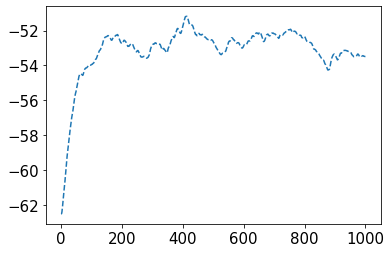

In [92]:
plt.plot(Y_test[idx], '--', label='real')

In [14]:
def variance_explained(x, y):
    err = np.sum(np.square(x - y))
    var = np.sum(np.square(y - np.mean(y)))
    return 1 - err / var

In [88]:
np.argmin(test_ve_b)

7

Text(0, 0.5, 'variance explained')

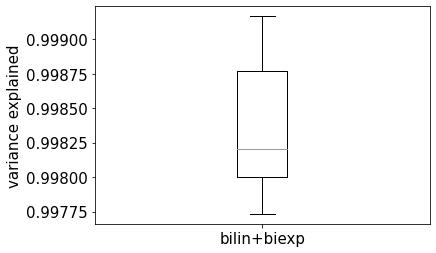

In [87]:
#Vars_bb = res.x
test_pred_b = hlm(X_test_array, Vars_bb[0:9], Vars_bb[9:18], Vars_bb[18:27], Vars_bb[27:63], Vars_bb[63])
#test_pred_non = hlm_non2(X_test_array, Vars_non[0:9], Vars_non[9:18], Vars_non[18:27], Vars_non[27], Vars_non[28], Vars_non[29])
#test_pred_l = hlm_l(X_test_array, Vars_l[0:9], Vars_l[9:18], Vars_l[18:27], Vars_l[27])
#test_pred_old = hlm_old(X_test_array, Vars_old[0:9], Vars_old[9:18], Vars_old[18], Vars_old[19], Vars_old[20])

test_ve_non = np.empty(X_test_array.shape[0])
test_ve_b = np.empty(X_test_array.shape[0])
test_ve_l = np.empty(X_test_array.shape[0])
test_ve_old = np.empty(X_test_array.shape[0])

for i in range(len(test_ve_b)):
    test_ve_b[i] = variance_explained(test_pred_b[i], Y_test_std[i])
    #test_ve_non[i] = variance_explained(test_pred_non[i], Y_test_std[i])
    #test_ve_l[i] = variance_explained(test_pred_l[i], Y_test_std[i])
    #test_ve_old[i] = variance_explained(test_pred_old[i], Y_test_std[i])
p = ['bilin+biexp']
plt.boxplot([test_ve_b],showfliers=False,labels=p)
#plt.ylim(0.95, 1)
plt.ylabel('variance explained')